In [1]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchmetrics,matplotlib

torch            : 1.10.1
pytorch_lightning: 1.5.1
torchmetrics     : 0.6.2
matplotlib       : 3.3.4



In [2]:
%load_ext pycodestyle_magic
%flake8_on --ignore W291,W293

<a href="https://pytorch.org"><img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.svg" width="90"/></a> &nbsp; &nbsp;&nbsp;&nbsp;<a href="https://www.pytorchlightning.ai"><img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.svg" width="150"/></a>

# Model Zoo -- Multilayer Perceptron with Dropout

## General settings and hyperparameters

- Here, we specify some general hyperparameter values and general settings
- Note that for small datatsets, it is not necessary and better not to use multiple workers as it can sometimes cause issues with too many open files in PyTorch. So, if you have problems with the data loader later, try setting `NUM_WORKERS = 0` instead.

In [3]:
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 0.005
NUM_WORKERS = 4

## Implementing a Neural Network` using PyTorch Lightning's `LightningModule`

- In this section, we set up the main model architecture using the `LightningModule` from PyTorch Lightning.
- We start with defining our neural network  model in pure PyTorch, and then we use it in the `LightningModule` to get all the extra benefits that PyTorch Lightning provides.

In [4]:
import torch
import torch.nn.functional as F


# Regular PyTorch Module
class PyTorchMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_units, dropout_proba, num_classes):
        super().__init__()

        # Initialize MLP layers
        all_layers = []
        for hidden_unit in hidden_units:
            layer = torch.nn.Linear(input_size, hidden_unit)
            all_layers.append(layer)
            all_layers.append(torch.nn.ReLU())
            all_layers.append(torch.nn.Dropout(dropout_proba))
            input_size = hidden_unit

        output_layer = torch.nn.Linear(
            in_features=hidden_units[-1],
            out_features=num_classes)

        all_layers.append(output_layer)
        self.model = torch.nn.Sequential(*all_layers)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # to make it work for image inputs
        x = self.model(x)
        return x  # x are the model's logits

In [5]:
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningMLP(pl.LightningModule):
    def __init__(self, model):
        super().__init__()

        # The inherited PyTorch module
        self.model = model

        # Save hyperparameters to the log directory
        self.save_hyperparameters()

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    # Defining the forward method is only necessary 
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)
        
    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, _, _ = self._shared_step(batch)
        self.log("train_loss", loss)
        
        # To account for Dropout behavior during evaluation
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc.update(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc.update(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return optimizer

## Setting up the dataset

- In this section, we are going to set up our dataset.

### Inspecting the dataset

In [6]:
import torch

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


train_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          shuffle=True)

test_dataset = datasets.MNIST(root='./data', 
                              train=False,
                              transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         drop_last=False,
                         shuffle=False)

# Checking the dataset
all_train_labels = []
all_test_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)

In [7]:
print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))

Training labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Training label distribution: tensor([5909, 6730, 5946, 6120, 5834, 5414, 5913, 6250, 5846, 5942])

Test labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Test label distribution: tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


### Performance baseline

- Especially for imbalanced datasets, it's quite useful to compute a performance baseline.
- In classification contexts, a useful baseline is to compute the accuracy for a scenario where the model always predicts the majority class -- you want your model to be better than that!

In [8]:
all_test_labels = all_test_labels.float()
majority_prediction = torch.argmax(all_test_labels)
baseline_acc = torch.mean((all_test_labels == majority_prediction).float())
print(f'Baseline ACC: {baseline_acc*100:.2f}%')

Baseline ACC: 10.28%


### Setting up a `DataModule`

- There are three main ways we can prepare the dataset for Lightning. We can
  1. make the dataset part of the model;
  2. set up the data loaders as usual and feed them to the fit method of a Lightning Trainer -- the Trainer is introduced in the next subsection;
  3. create a LightningDataModule.
- Here, we are going to use approach 3, which is the most organized approach. The `LightningDataModule` consists of several self-explanatory methods as we can see below:


In [9]:
import os

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        
    def prepare_data(self):
        datasets.MNIST(root=self.data_path,
                       download=True)
        return

    def setup(self, stage=None):
        # Note transforms.ToTensor() scales input images
        # to 0-1 range
        train = datasets.MNIST(root=self.data_path, 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=False)

        self.test = datasets.MNIST(root=self.data_path, 
                                   train=False, 
                                   transform=transforms.ToTensor(),
                                   download=False)

        self.train, self.valid = random_split(train, lengths=[55000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(dataset=self.train, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=True,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(dataset=self.valid, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(dataset=self.test, 
                                 batch_size=BATCH_SIZE, 
                                 drop_last=False,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS)
        return test_loader

- Note that the `prepare_data` method is usually used for steps that only need to be executed once, for example, downloading the dataset; the `setup` method defines the the dataset loading -- if you run your code in a distributed setting, this will be called on each node / GPU. 
- Next, lets initialize the `DataModule`; we use a random seed for reproducibility (so that the data set is shuffled the same way when we re-execute this code):

In [10]:
torch.manual_seed(1) 
data_module = DataModule(data_path='./data')

## Training the model using the PyTorch Lightning Trainer class

- Next, we initialize our model.
- Also, we define a call back so that we can obtain the model with the best validation set performance after training.
- PyTorch Lightning offers [many advanced logging services](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) like Weights & Biases. Here, we will keep things simple and use the `CSVLogger`:

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


pytorch_model = PyTorchMLP(
    input_size=28*28,
    hidden_units=(128, 256),
    dropout_proba=0.5,
    num_classes=10
)

lightning_model = LightningMLP(pytorch_model)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='max', monitor="valid_acc")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="my-mlp")

- Now it's time to train our model:

In [12]:
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=100)

trainer.fit(model=lightning_model, datamodule=data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | PyTorchMLP | 136 K 
1 | train_acc | Accuracy   | 0     
2 | valid_acc | Accuracy   | 0     
3 | test_acc  | Accuracy   | 0     
-----------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Evaluating the model

- After training, let's plot our training ACC and validation ACC using pandas, which, in turn, uses matplotlib for plotting (you may want to consider a [more advanced logger](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) that does that for you):

<AxesSubplot:xlabel='Epoch', ylabel='ACC'>

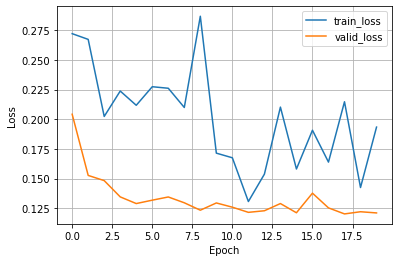

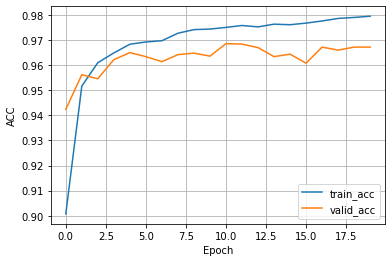

In [13]:
import pandas as pd


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='ACC')

- The `trainer` automatically saves the model with the best validation accuracy automatically for us, we which we can load from the checkpoint via the `ckpt_path='best'` argument; below we use the `trainer` instance to evaluate the best model on the test set:

In [14]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

Restoring states from the checkpoint path at logs/my-mlp/version_7/checkpoints/epoch=10-step=2353.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/my-mlp/version_7/checkpoints/epoch=10-step=2353.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9706000089645386}
--------------------------------------------------------------------------------


[{'test_acc': 0.9706000089645386}]

## Predicting labels of new data

- You can use the `trainer.predict` method on a new `DataLoader` or `DataModule` to apply the model to new data.
- Alternatively, you can also manually load the best model from a checkpoint as shown below:

In [15]:
path = f'{trainer.logger.log_dir}/checkpoints/epoch=10-step=2353.ckpt'

lightning_model = LightningMLP.load_from_checkpoint(path)

- Note that our PyTorch model, which is passed to the Lightning model requires input arguments. However, this is automatically being taken care of since we used `self.save_hyperparameters()` in our PyTorch model's `__init__` method.
- Now, below is an example applying the model manually. Here, pretend that the `test_dataloader` is a new data loader.

In [16]:
test_dataloader = data_module.test_dataloader()

all_predicted_labels = []
for batch in test_dataloader:
    features, _ = batch
    logits = lightning_model.model(features)
    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    
all_predicted_labels = torch.cat(all_predicted_labels)
all_predicted_labels[:5]

tensor([7, 2, 1, 0, 4])